Code revised by Harry Wang based on https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

In [59]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

import lightgbm as lgbm

In [60]:
# load nodes details
with open("./data/fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("./data/fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)  # both are lists

(621, 2102)

In [61]:
# captture nodes in 2 separate lists to form a dataframe
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 633318.51it/s]


In [62]:
# fb_df is the original graph with links
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


In [63]:
fb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node_1  2102 non-null   object
 1   node_2  2102 non-null   object
dtypes: object(2)
memory usage: 33.0+ KB


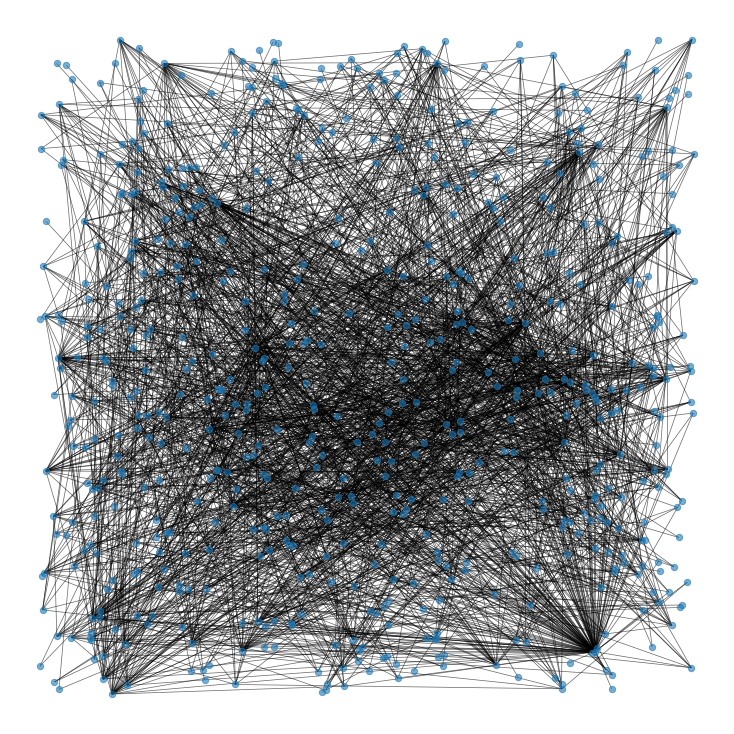

In [64]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [65]:
# Retrieve Unconnected Node Pairs – Negative Samples
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [66]:
node_list[:10] # all nodes 620 pages

['0', '1', '2', '3', '557', '4', '5', '6', '7', '8']

In [67]:
# node to node adj matrix
adj_G

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
adj_G.shape

(620, 620)

In [69]:
print(nx.shortest_path_length(G, str(273), str(58)), adj_G[273, 58])
print(nx.shortest_path_length(G, str(0), str(58)), adj_G[0, 58])

4 0.0
1 0.0


In [70]:
adj_G[273, 58]

0.0

In [71]:
adj_G.sum()  # number of edges/1s

4193.0

In [72]:
adj_G.size

384400

In [73]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset, adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <= 2:  # necessary?
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i], node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:20<00:00, 30.88it/s] 


In [74]:
len(all_unconnected_pairs)

19018

In [75]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [76]:
data.head()

,node_1,node_2,link
0,0,22,0
1,0,526,0
2,0,36,0
3,0,54,0
4,0,56,0


In [58]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

  7%|▋         | 137/2102 [00:01<00:28, 69.95it/s] 


KeyboardInterrupt: 

In [23]:
# We have over 1400 links that we can drop from the graph. 
# These dropped edges will act as positive training examples during the link prediction model training.
len(omissible_links_index)

1483

In [24]:
# the current unconnected nodes (negative training samples): 19018
data.shape

(19018, 3)

In [25]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [26]:
fb_df_ghost

,node_1,node_2,link
0,0,276,1
1,0,58,1
2,0,132,1
3,0,603,1
4,0,398,1
...,...,...,...
2083,576,601,1
2088,584,603,1
2093,556,556,1
2095,597,601,1


In [27]:
# add the positive traning samples 20501 = 19018 + 1483
data.shape

(20501, 3)

In [28]:
data.head(10)

,node_1,node_2,link
0,0,22,0
1,0,526,0
2,0,36,0
3,0,54,0
4,0,56,0
5,0,65,0
6,0,66,0
7,0,86,0
8,0,88,0
9,0,89,0


In [29]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

In [30]:
# drop removable edges to build a new graph so that we can use node2vec to get the node embeddings
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)
print(len(fb_df_partial))
# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

619


In [31]:
fb_df_partial.head()

,node_1,node_2
5,0,555
7,1,611
10,2,345
20,3,228
24,557,151


In [32]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


In [33]:
x = [(n2w_model[str(i)] + n2w_model[str(j)]) for i, j in zip(data['node_1'], data['node_2'])]

<ipython-input-33-88a6d52216ab>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x = [(n2w_model[str(i)] + n2w_model[str(j)]) for i, j in zip(data['node_1'], data['node_2'])]


In [34]:
x[0]

array([-1.5213425 , -0.16387226,  0.27455026, -0.6232109 , -0.02978301,
        0.14026442, -0.18521014, -0.6517645 , -0.38941723,  0.03596449,
       -0.6123307 ,  0.7797141 ,  0.57608324, -0.55456036, -1.0098476 ,
        0.57121503, -0.31834272,  0.12410696, -1.7939783 , -0.79261553,
        0.7484038 ,  0.39583397,  0.21352468,  0.8913857 ,  0.5331808 ,
        0.555489  , -0.3627438 ,  0.7554636 ,  0.32549232, -1.1377137 ,
        0.21633095, -0.39852867, -0.02382672,  0.5164684 , -0.16597116,
        0.40498155, -0.8002267 ,  0.27990693, -1.2802519 , -1.0932944 ,
        0.14045097, -0.13254955, -1.4802899 , -0.85533327,  0.19842671,
        1.066166  , -1.1660213 ,  0.91124576, -1.0770869 , -0.41971964,
       -1.1360114 ,  0.94944334, -0.05858896, -0.15939277, -0.15798147,
        0.51501805,  0.16099648,  0.27073377, -0.17604867,  0.44421715,
       -1.0468506 ,  0.15184161,  0.07034584, -0.49013135,  0.03380323,
        0.86067986, -0.26405525, -1.5036556 , -0.72028965,  0.43

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [36]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/Users/harrywang/sandbox/tutorial-buffet/link-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [37]:
predictions = lr.predict_proba(xtest)

In [38]:
roc_auc_score(ytest, predictions[:,1])

0.8025394535573492

In [39]:
# lgbm model
train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[LightGBM] [Info] Number of positive: 1062, number of negative: 13288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14350, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074007 -> initscore=-2.526707
[LightGBM] [Info] Start training from score -2.526707
[1]	valid_0's auc: 0.710272
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.756986
[3]	valid_0's auc: 0.784768
[4]	valid_0's auc: 0.801854
[5]	valid_0's auc: 0.816813
[6]	valid_0's auc: 0.827481
[7]	valid_0's auc: 0.831378
[8]	valid_0's auc: 0.834682
[9]	valid_0's auc: 0.836673
[10]	valid_0's auc: 0.844412
[11]	valid_0's auc: 0.848359
[12]	valid_0's auc: 0.853434
[13]	valid_0's auc: 0.854237
[14]	valid_0's auc: 0.855483
[15]	valid_0's auc: 0.85915
[16]	valid_0's a